In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy
import scipy.io as sio
import torch
import torch.nn.functional as F
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import LinearLR

from splice import splice_model
from splice.base import *
from splice.loadCellsFile import *
from splice.utilities import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocessing
The preprocessing code below is adapted from Carlos' notebook, with minor changes to variable names, using numpy instead of pandas, and slight optimizations

### Load the data

In [2]:
ratname = "A324"
sessdate = "2023_07_21"

session_info = mat2pyCellFileCleanup("../data/uberphys/%s_%s.mat" % (ratname, sessdate))
session_data = scipy.io.loadmat("../data/uberphys/%s_%s.mat" % (ratname, sessdate)) 

included_trials = np.argwhere((session_info["Trials"]['violated'] == 0) & ((~np.isnan(session_info["Trials"]["pokedR"])))).squeeze()
n_trials = included_trials.shape[0]
cpoke_in = session_info["Trials"]["stateTimes"]["cpoke_in"][included_trials]
cpoke_out = session_info["Trials"]["stateTimes"]["cpoke_out"][included_trials]

included_cells = np.argwhere(session_data['standard_inclusion_criteria'].squeeze()).squeeze()
brain_region = np.array(session_info['region'])[included_cells]

print(f"We have {n_trials} non-violation, valid trials")

No region found for cell 190, entering 'None'
No region found for cell 191, entering 'None'
No region found for cell 192, entering 'None'
No region found for cell 193, entering 'None'
No region found for cell 194, entering 'None'
No region found for cell 195, entering 'None'
No region found for cell 196, entering 'None'
No region found for cell 197, entering 'None'
No region found for cell 198, entering 'None'
No region found for cell 199, entering 'None'
No region found for cell 200, entering 'None'
No region found for cell 201, entering 'None'
No region found for cell 202, entering 'None'
No region found for cell 203, entering 'None'
No region found for cell 547, entering 'None'
No region found for cell 2202, entering 'None'
No region found for cell 2203, entering 'None'
No region found for cell 2204, entering 'None'
We have 714 non-violation, valid trials


### Bin and smooth firing rates
Here we bin spikes into 10 ms bins; then smooth with a 60ms sd Gaussian; then subsample down by 3.

We end up with **time_in_session**, a time in session vector, and **smoothed_rates**, an nCells x nTimebins matrix of smoothed firing rates (no trial structure yet)

In [3]:
spike_times= session_data['raw_spike_time_s'].squeeze()[included_cells]
n_cells = spike_times.shape[0]
print(f"We have {n_cells} cells total")

We have 2621 cells total


In [4]:
min_time = np.inf
max_time = -np.inf

for cell in spike_times:
    if len(cell) > 0:
        min_time = min(min_time, cell[0])
        max_time = max(max_time, cell[-1])

min_time = min_time[0] # type: ignore
max_time = max_time[0] # type: ignore
print(f"Min time: {min_time}, Max time: {max_time}")
    

Min time: 1658.66378, Max time: 14362.02429


In [5]:
dt = 0.01
bin_times = np.arange(np.floor(min_time), np.ceil(max_time), dt)
smooth_sigma = 0.06 # in seconds
subsample_factor = 3

filepath = f"../data/uberphys/%s_%s_%.3f_smoothed_rates.npz" % (ratname, sessdate, smooth_sigma)

if(os.path.exists(filepath)):
    data = np.load(filepath)
    smoothed_rates = data['smoothed_rates']
    time_in_session = data['time_in_session']
    print("Loaded smoothed rates from file")
else:
    time_in_session = bin_times[0:-1:subsample_factor]
    smoothed_rates = np.zeros((n_cells, len(time_in_session)))

    for cell in range(n_cells):
        if smooth_sigma == 0:
            smoothed_rates[cell] = binEvents(spike_times[cell], bin_times, dt)[0:-1:subsample_factor]/dt
        else:
            smoothed_rates[cell] = smoothIt(binEvents(spike_times[cell], bin_times, dt), smooth_sigma/dt)[0:-1:subsample_factor]/dt
        
        print(f"Done with {cell+1}/{n_cells} cells", end="\r")
    
    np.savez_compressed(filepath, smoothed_rates=smoothed_rates, time_in_session=time_in_session)

Loaded smoothed rates from file


### Put times into trials

We'll make a tensor **trial_rates**, nTrials x nCells x nTimebins, where nTimebins now just runs over `cpoke_in` to `cpoke_out`.

Note that different trials are different lengths.  We're timelocked to `cpoke_in`, but some will have `np.nan`s in their last timebins

In [6]:
trial_length = 0.5

trial_rates = np.zeros((n_trials, n_cells, int(np.ceil(trial_length/(dt*subsample_factor)))))
trial_times = list(np.arange(trial_rates.shape[-1])*(dt*subsample_factor))

for trial in range(n_trials):
    start = cpoke_in[trial]
    end = cpoke_out[trial]

    rates = smoothed_rates[:, (time_in_session >= start) & (time_in_session < end)]

    if rates.shape[1] > trial_rates.shape[-1]:
        add_length = rates.shape[1] - trial_rates.shape[-1]
        trial_rates = np.concatenate((trial_rates, np.nan * np.zeros((n_trials, n_cells, add_length))), axis=-1)

        new_times = list(trial_times[-1] + np.arange(1, (add_length+1))*(dt*subsample_factor))

        if new_times:
            trial_times.extend(new_times)
    
    trial_rates[trial, :, :rates.shape[1]] = rates

trial_times = np.array(trial_times)

## Autoencoder vs PCA

### Pick out cells from a brain region (Cg1)

In [7]:
np.unique(brain_region)

array(['ADS', 'CC', 'Cg1', 'DGd', 'DGv', 'DS', 'GP', 'M1', 'M2', 'MGB',
       'NAc', 'None', 'PrL', 'S1', 'SBN', 'TS'], dtype='<U4')

In [24]:
selected_region = "Cg1"
selected_cells = np.argwhere(brain_region == selected_region).squeeze()

selected_spike_times = spike_times[selected_cells]
selected_smoothed_rates = smoothed_rates[selected_cells]
n_cells_selected = selected_spike_times.shape[0]
print(f"We have {selected_spike_times.shape[0]} cells in {selected_region}")

We have 305 cells in Cg1


In [23]:
train_data, test_data = train_test_split(trial_rates[:, selected_cells, :], test_size=0.15)

train_data = train_data.transpose(0, 2, 1).reshape(-1, n_cells_selected)
train_data = train_data[~np.isnan(train_data).any(axis=1)]

test_data = test_data.transpose(0, 2, 1).reshape(-1, n_cells_selected)
test_data = test_data[~np.isnan(test_data).any(axis=1)]

NameError: name 'selected_cells' is not defined

### Do PCA

In [143]:
pca = PCA(n_components=n_cells_selected)
pca.fit(train_data)

PCA(n_components=305)

In [144]:
s1 = np.var(test_data - train_data.mean(axis=0))
s2 = np.var(test_data)
test_var_explained = 1 - s1/s2
print(f"Variance explained by mean: {test_var_explained}")

Variance explained by mean: 0.480078345688685


Text(0, 0.5, 'Cumulative Variance Explained')

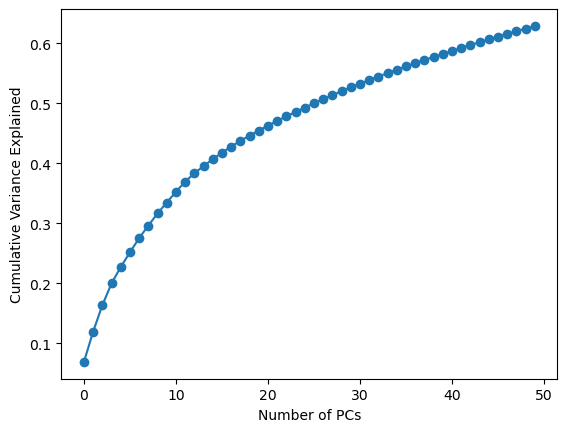

In [145]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:50], marker='o'); 
plt.xlabel("Number of PCs"); plt.ylabel("Cumulative Variance Explained")

In [146]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

for dim in [2,3,5,10,20, 50]:
    test_pcs = pca.transform(test_data)
    test_pcs[:, dim:] = 0
    test_proj = pca.inverse_transform(test_pcs)

    s1 = np.var(test_data-test_proj)
    s2 = np.var(test_data - test_data.mean(axis=0))
    test_var_explained = 1 - s1/s2

    print(f"With {dim} PCs, we can explain {explained_variance[dim-1]:.4f} of the training variance and {test_var_explained:.4f} of the test variance. The MSE is {F.mse_loss(torch.Tensor(test_proj),torch.Tensor(test_data)):.4f}")

With 2 PCs, we can explain 0.1194 of the training variance and 0.1158 of the test variance. The MSE is 22.6690
With 3 PCs, we can explain 0.1635 of the training variance and 0.1592 of the test variance. The MSE is 21.5559
With 5 PCs, we can explain 0.2272 of the training variance and 0.2244 of the test variance. The MSE is 19.8842
With 10 PCs, we can explain 0.3347 of the training variance and 0.3228 of the test variance. The MSE is 17.3596
With 20 PCs, we can explain 0.4548 of the training variance and 0.4446 of the test variance. The MSE is 14.2386
With 50 PCs, we can explain 0.6293 of the training variance and 0.6151 of the test variance. The MSE is 9.8667


In [147]:
explained_variance[0]

0.06880606394176564

### Do Autoencoder

In [170]:
class Encoder(nn.Module):
    def __init__(self, nInputCells, nHiddensVector, bottleneckDim,
                 nonlinearity = nn.ReLU()):
        super(Encoder, self).__init__()

        self.nHiddensVector = nHiddensVector
        self.nLayers        = len(nHiddensVector)
        self.bottleneckDim  = bottleneckDim
        self.encoderLayers  = nn.ModuleList()
        self.nInputCells    = nInputCells

        for i in range(self.nLayers):
            if i == 0:
                self.encoderLayers.append(nn.Linear(self.nInputCells, nHiddensVector[i]))
            else:
                self.encoderLayers.append(nn.Linear(nHiddensVector[i-1], nHiddensVector[i]))
            self.encoderLayers.append(nonlinearity)

        self.encoderLayers.append(nn.Linear(nHiddensVector[-1], bottleneckDim))

    def forward(self, x):
        for layer in self.encoderLayers:
            x = layer(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, bottleneckDim, nHiddensVector, nOutputCells,
                 nonlinearity = nn.ReLU()):
        super(Decoder, self).__init__()

        self.nHiddensVector = nHiddensVector
        self.nLayers        = len(nHiddensVector)
        self.bottleneckDim  = bottleneckDim
        self.decoderLayers  = nn.ModuleList()
        self.nOutputCells   = nOutputCells

        for i in range(self.nLayers):
            if i == 0:
                self.decoderLayers.append(nn.Linear(bottleneckDim, nHiddensVector[i]))
            else:
                self.decoderLayers.append(nn.Linear(nHiddensVector[i-1], nHiddensVector[i]))
            self.decoderLayers.append(nonlinearity)

        self.decoderLayers.append(nn.Linear(nHiddensVector[-1], nOutputCells))

    def forward(self, x):
        for layer in self.decoderLayers:
            x = layer(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, nInputCells, nHiddensVector, bottleneckDim,
                 nonlinearity = nn.ReLU()):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(nInputCells, nHiddensVector, bottleneckDim, nonlinearity)
        self.decoder = Decoder(bottleneckDim, nHiddensVector[::-1], nInputCells, nonlinearity)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def trainAutoencoderWithValidation(model, data, nEpochs, learningRate, 
                                   lossFunction, optimizer, validationData,
                                   printEvery=100, verbose=True):
    
    scheduler = LinearLR(optimizer, start_factor=1, end_factor=1/10, total_iters=nEpochs)

    for epoch in range(nEpochs):
        print(epoch, end="\r")
        optimizer.zero_grad()
        output = model(data)
        loss = lossFunction(output, data)
        loss.backward()
        optimizer.step()

        scheduler.step()
        
        if verbose:
            if epoch % printEvery == 0:
                output = model(validationData)
                validationLoss = lossFunction(output, validationData)
                print("Epoch %d, Loss: %f, Validation loss: %f" % (epoch, loss.item(), validationLoss.item()))            
    return model

In [165]:
model = Autoencoder(n_cells_selected, [100,50,50,50,20], 20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
lossFunction = nn.MSELoss()

train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)

trainAutoencoderWithValidation(model, train_data_tensor, 25000, 0.001, lossFunction, optimizer, test_data_tensor, printEvery=100)

Epoch 0, Loss: 68.304047, Validation loss: 67.454216
Epoch 100, Loss: 25.759756, Validation loss: 25.433765
Epoch 200, Loss: 25.706358, Validation loss: 25.380646
Epoch 300, Loss: 25.693777, Validation loss: 25.367201
Epoch 400, Loss: 25.688129, Validation loss: 25.361633
Epoch 500, Loss: 25.682161, Validation loss: 25.356152
Epoch 600, Loss: 25.672859, Validation loss: 25.347681
Epoch 700, Loss: 25.653549, Validation loss: 25.329933
Epoch 800, Loss: 25.573576, Validation loss: 25.254227
Epoch 900, Loss: 25.369173, Validation loss: 25.033264
Epoch 1000, Loss: 23.827751, Validation loss: 23.561522
Epoch 1100, Loss: 23.133062, Validation loss: 22.932308
Epoch 1200, Loss: 22.586386, Validation loss: 22.443880
Epoch 1300, Loss: 22.418783, Validation loss: 22.023981
Epoch 1400, Loss: 21.198013, Validation loss: 21.129887
Epoch 1500, Loss: 20.791790, Validation loss: 20.712593
Epoch 1600, Loss: 21.021891, Validation loss: 20.474222
Epoch 1700, Loss: 20.227757, Validation loss: 20.120094
Epoc

Autoencoder(
  (encoder): Encoder(
    (encoderLayers): ModuleList(
      (0): Linear(in_features=305, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU()
      (6): Linear(in_features=50, out_features=50, bias=True)
      (7): ReLU()
      (8): Linear(in_features=50, out_features=20, bias=True)
      (9): ReLU()
      (10): Linear(in_features=20, out_features=20, bias=True)
    )
  )
  (decoder): Decoder(
    (decoderLayers): ModuleList(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU()
      (6): Linear(in_features=50, out_features=50, bias=True)
      (7): ReLU()
      (8): Linear(in_features=50, out_features=100, bias=True)
      (9): ReLU()


In [167]:
def explainedVariance(data, model, train_data):
    mu = train_data.mean(axis=0).cpu().detach().numpy()
    return 1 - np.var((data - model(data)).cpu().detach().numpy())/np.var(data.cpu().detach().numpy()-mu)
# remainingVar = np.var((testData-model(testData)).cpu().detach().numpy())
# totalVar = np.var(testData.cpu().detach().numpy()-mu)
# fracExplainedVar = 1 - remainingVar/totalVar

bottleneckDim = 2

print("bottleneckDim=%d: frac test data variance explained: " % bottleneckDim, explainedVariance(test_data_tensor, model, train_data_tensor))
print("bottleneckDim=%d: frac train data variance explained: " % bottleneckDim, explainedVariance(train_data_tensor, model, train_data_tensor))

bottleneckDim=2: frac test data variance explained:  0.41604405641555786
bottleneckDim=2: frac train data variance explained:  0.44479167461395264


### Automate PCA-Autoencoder comparison

In [171]:
def compare_pca_ae(selected_region, brain_region, trial_rates, ae_dims=[1,2,3,5,10,20,50], max_dim = 50):
    ae_dims = np.array(ae_dims)
    ae_dims = ae_dims[ae_dims <= max_dim]

    # select cells and trials
    selected_cells = np.argwhere(brain_region == selected_region).squeeze()
    n_cells_selected = selected_cells.shape[0]
    print(f"We have {selected_cells.shape[0]} cells in {selected_region}")

    train_data, test_data = train_test_split(trial_rates[:, selected_cells, :], test_size=0.15)

    train_data = train_data.transpose(0, 2, 1).reshape(-1, n_cells_selected)
    train_data = train_data[~np.isnan(train_data).any(axis=1)]

    test_data = test_data.transpose(0, 2, 1).reshape(-1, n_cells_selected)
    test_data = test_data[~np.isnan(test_data).any(axis=1)]

    # Do PCA
    pca = PCA(n_components=n_cells_selected)
    pca.fit(train_data)

    pca_var_explained = np.zeros(min(max_dim, n_cells_selected))
    for dim in range(1,min(max_dim, n_cells_selected)+1):
        test_pcs = pca.transform(test_data)
        test_pcs[:, dim:] = 0
        test_proj = pca.inverse_transform(test_pcs)

        s1 = np.var(test_data-test_proj)
        s2 = np.var(test_data - train_data.mean(axis=0))
        pca_var_explained[dim-1] = 1 - s1/s2

    # Do AE
    ae_var_explained = np.zeros(len(ae_dims))

    for i, dim in enumerate(ae_dims):
        #train 
        print(f"Training {dim}-dimensional autoencoder")
        model = Autoencoder(n_cells_selected, [100,50,50,50,20], dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
        lossFunction = nn.MSELoss()

        train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
        test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)

        trainAutoencoderWithValidation(model, train_data_tensor, 25000, 0.001, lossFunction, optimizer, test_data_tensor, printEvery=100, verbose=False)

        ae_var_explained[i] = explainedVariance(test_data_tensor, model, train_data_tensor)

    plt.figure()
    plt.title(f"Explained variance in {selected_region}")
    plt.plot(np.arange(0,min(max_dim, n_cells_selected)+1), np.concatenate(([0], pca_var_explained)), label="PCA", marker='o')
    plt.plot(np.concatenate(([0],ae_dims)), np.concatenate(([0], ae_var_explained)), label="AE", marker='o')
    plt.legend()
    plt.xlabel("Number of dimensions")
    plt.ylabel("Explained variance")
    plt.ylim(0,1)


    plt.savefig(f"../results/uberphys/pca_ae_comparison/{selected_region}_pca_ae.png")
    np.savez_compressed(
        f"../results/uberphys/pca_ae_comparison/{selected_region}_pca_ae", 
        pca_var_explained=pca_var_explained, 
        ae_var_explained=ae_var_explained, 
        ae_dims=ae_dims
        )

    return pca_var_explained, ae_var_explained
    

Processing ADS
We have 318 cells in ADS
Training 1-dimensional autoencoder
Training 2-dimensional autoencoder
Training 3-dimensional autoencoder
Training 5-dimensional autoencoder
Training 10-dimensional autoencoder
Training 20-dimensional autoencoder
Processing CC
We have 53 cells in CC
Training 1-dimensional autoencoder
Training 2-dimensional autoencoder


KeyboardInterrupt: 

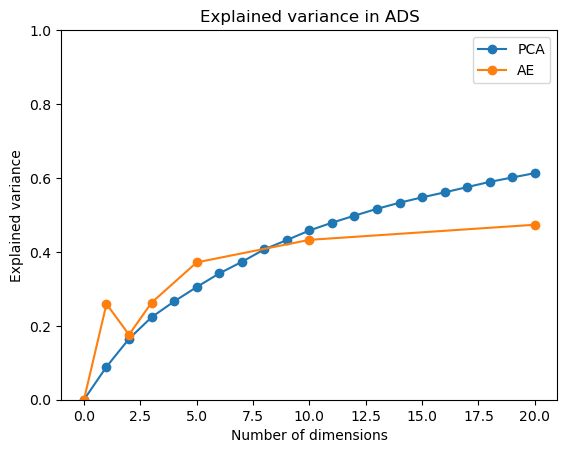

In [172]:
for region in np.unique(brain_region):
    if region != "None":
        print(f"Processing {region}")
        compare_pca_ae(region, brain_region, trial_rates, max_dim=20)

## RRR vs Cross-encoder

In [77]:
# select cells and trials
ads_cells = np.argwhere(brain_region == "M1").squeeze()
n_cells_ads = ads_cells.shape[0]
print(f"We have {ads_cells.shape[0]} cells in ADS")

m1_cells = np.argwhere(brain_region == "ADS").squeeze()
n_cells_m1 = m1_cells.shape[0]
print(f"We have {m1_cells.shape[0]} cells in M1")

train_ads = train_data[:, ads_cells, :].transpose(0,2,1).reshape(-1, n_cells_ads)
train_m1 = train_data[:, m1_cells, :].transpose(0,2,1).reshape(-1, n_cells_m1)
train_ads = train_ads[~np.isnan(train_ads).any(axis=1)]
train_m1 = train_m1[~np.isnan(train_m1).any(axis=1)]

test_ads = test_data[:, ads_cells, :].transpose(0,2,1).reshape(-1, n_cells_ads)
test_m1 = test_data[:, m1_cells, :].transpose(0,2,1).reshape(-1, n_cells_m1)
test_ads = test_ads[~np.isnan(test_ads).any(axis=1)]
test_m1 = test_m1[~np.isnan(test_m1).any(axis=1)]

We have 149 cells in ADS
We have 318 cells in M1


### RRR

In [78]:
class RRR(nn.Module):
    def __init__(self, n_inputs, n_outputs, bottle_dim):
        super().__init__()

        self.encoder = nn.Linear(n_inputs, bottle_dim)
        self.decoder = nn.Linear(bottle_dim, n_outputs)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat

In [79]:
train_ads = torch.Tensor(train_ads).to(device)
test_ads = torch.Tensor(test_ads).to(device)

train_m1 = torch.Tensor(train_m1).to(device)
test_m1 = torch.Tensor(test_m1).to(device)

In [80]:
dims = [1,2,3,5,10,15,20,30,50]
accs = np.zeros((len(dims)))

for i, dim in enumerate(dims):
    print(f"DIM {dim}")
    rrr = RRR(n_cells_m1, n_cells_ads, dim).to(device)

    optimizer = torch.optim.Adam(rrr.parameters(), lr=0.003)
    lossFunction = nn.MSELoss()
    n_epochs = 10000

    for epoch in range(n_epochs):
        print(epoch, end="\r")
        optimizer.zero_grad()
        output = rrr(train_m1)
        loss = lossFunction(output, train_ads)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            output = rrr(test_m1)
            validationLoss = lossFunction(output, test_ads)
            print("Epoch %d, Loss: %f, Validation loss: %f" % (epoch, loss.item(), validationLoss.item()))  

            accs[i] = validationLoss


DIM 1
Epoch 0, Loss: 261.818451, Validation loss: 262.195557
Epoch 100, Loss: 224.492020, Validation loss: 224.087341
Epoch 200, Loss: 120.620132, Validation loss: 120.184608
Epoch 300, Loss: 88.020828, Validation loss: 88.705040
Epoch 400, Loss: 85.422745, Validation loss: 86.383110
Epoch 500, Loss: 85.303131, Validation loss: 86.288170
Epoch 600, Loss: 85.266968, Validation loss: 86.256386
Epoch 700, Loss: 85.230896, Validation loss: 86.223572
Epoch 800, Loss: 85.192909, Validation loss: 86.187614
Epoch 900, Loss: 85.152962, Validation loss: 86.148766
Epoch 1000, Loss: 85.111053, Validation loss: 86.107399
Epoch 1100, Loss: 85.067200, Validation loss: 86.063622
Epoch 1200, Loss: 85.021385, Validation loss: 86.017578
Epoch 1300, Loss: 84.973595, Validation loss: 85.969398
Epoch 1400, Loss: 84.923775, Validation loss: 85.919098
Epoch 1500, Loss: 84.871902, Validation loss: 85.866707
Epoch 1600, Loss: 84.817894, Validation loss: 85.812202
Epoch 1700, Loss: 84.761703, Validation loss: 85

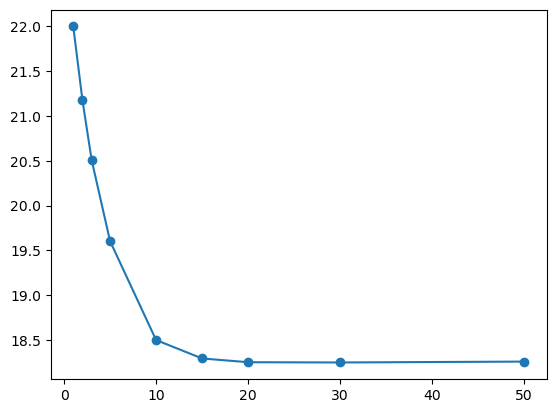

In [74]:
plt.plot(dims, accs, marker='o');

In [75]:
mu = train_ads.mean(dim=0).cpu().detach().numpy()
var = 1 - np.var((test_ads - rrr(test_m1)).cpu().detach().numpy())/np.var(test_ads.cpu().detach().numpy()-mu)

In [76]:
var

0.19883745908737183